In [1]:
# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
from scipy.linalg import block_diag
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')
import datetime

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from DataMaker_New import dataCleaner_new
from ESN import EchoState
from Loss import loss

In [4]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 12, 31)
train_valid_split = 0.979
valid_test_split = 0.98
u_dim = 10
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

# train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 1106 days of train data
Attached 5530 train option observations
Attached 1 days of validation data
Attached 5 validation option observations
Attached 23 days of test data
Attached 115 test option observations


In [5]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    try:
        return np.divide(1, 1+np.exp(-x))
    except RuntimeWarning:
        return np.zeros(x.shape[0])+0.0001
        

def ESNf(inner_state, dt, **fx_args):
    """
    :params inner_state [theta_t, G, G_in, b]
    
    **fx_args
    :G_idx    start idx of G
    :G_in_idx start idx of G_in
    :b_idx    start idx of b
    :params u_quad_now u_t^2
    """
    G_idx = fx_args["G_idx"]
    G_in_idx = fx_args["G_in_idx"]
    b_idx = fx_args["b_idx"]
    u_quad_now = fx_args["u_quad_now"].reshape([-1, 1])
    
   
    theta_now = inner_state[: G_idx].reshape([-1,1])
    G_flat = inner_state[G_idx : G_in_idx]
    G_in_flat = inner_state[G_in_idx : b_idx]
    
    theta_dim = int(math.sqrt(len(G_flat)))
    u_dim = int(len(G_in_flat) / theta_dim)
    
    
    G = G_flat.reshape([theta_dim, theta_dim])
    G_in = G_in_flat.reshape([theta_dim, u_dim])
    b = inner_state[b_idx:].reshape([-1,1])
    
    
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    
    
    next_state = np.concatenate((theta_next.flatten(), G.flatten(), G_in.flatten(), b.flatten()))
    
    return next_state
    

def BSf(inner_state_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :G_idx    start idx of G
    :G_in_idx start idx of G_in
    :b_idx    start idx of b
    
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    G_idx = hx_args["G_idx"]
    G_in_idx = hx_args["G_in_idx"]
    b_idx = hx_args["b_idx"]
    
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    theta_t = inner_state_t[: G_idx].reshape([-1,1])
    G_flat = inner_state_t[G_idx : G_in_idx]
    G_in_flat = inner_state_t[G_in_idx : b_idx] 

    
    theta_dim = int(math.sqrt(len(G_flat)))
    u_dim = int(len(G_in_flat) / theta_dim)
    
    G = G_flat.reshape([theta_dim, theta_dim])
    G_in = G_in_flat.reshape([theta_dim, u_dim])
    b = inner_state_t[b_idx:].reshape([-1,1])
    
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


# 睡觉专区

In [6]:
np.random.seed(1234)
gradient = grad(loss)
num_iters = 30


forward_k = 20

error_for_all_theta_dim = []

for theta_dim in np.arange(8, 9, 1):


    G_idx = theta_dim
    G_in_idx = G_idx + theta_dim**2
    b_idx = G_in_idx + u_dim*theta_dim


    print("theta_dim = {}".format(theta_dim))
    connectivity = 0.4
    spectral_radius = 0.98
    bday_p_year = 252
    bias = -1.9

    v_scale = 100.0
    target_var = 1e-6
    chi_mu = math.sqrt(2)* math.gamma((theta_dim+1)/2) / math.gamma(theta_dim/2)
    W_scale = target_var+chi_mu

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    total_dim = ESN.theta_dim + theta_dim**2 + u_dim*theta_dim + theta_dim
    W = np.eye(total_dim)*W_scale
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    best_train_error = 100
    best_train_itr = 0

    dt=1
    points = MerweScaledSigmaPoints(total_dim, alpha=.001, beta=2., kappa=0)
    ukf = UnscentedKalmanFilter(dim_x=total_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
    initial_theta = np.ones(ESN.theta_dim)* 0.1
    initial_state = np.concatenate((initial_theta, (ESN.G).flatten(), (ESN.G_in).flatten(), (ESN.b).flatten()))
    ukf.x = initial_state # initial state
    ukf.P *= 0.01 # initial uncertainty
    ukf.R = np.diag([v]*topK) # 1 standard
    ukf.Q = W
    
    for forward_backward_itr in range(num_iters):
        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(train_data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = train_data[day][1] 
            u_t = train_data[day][2].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = train_data[day][3]

            ## Option wise data
            y_t = train_data[day][0]["spotclose"].values
            K_t = train_data[day][0]["strike_price"].values
            today = [d.date() for d in train_data[day][0]["date"]]
            expireday = [d.date() for d in train_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday) / bday_p_year


            ukf.predict(fx = ESNf, 
                        G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                        u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, 
                       G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                       p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s = ms, Cs
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother_alternative(ms, Cs, fx=ESNf,
                                                            G_idx=G_idx,
                                                            G_in_idx=G_in_idx,
                                                            b_idx=b_idx,
                                                            u_quad_s=u_quad_s)
        
        num_to_average = 5
        theta_last_m = ms_s[-1][:G_idx]
        theta_last_C = Cs_s[-1][:G_idx, :G_idx]
        weight_last_m = np.array(ms_s[-num_to_average:])[:, G_idx:]
        weight_last_C = np.array(Cs_s[-num_to_average:])[:, G_idx:, G_idx:]
        avg_weight_last_m = np.average(weight_last_m, axis=0)
        avg_weight_last_C = np.average(weight_last_C, axis=0)
        ukf.x = np.concatenate((theta_last_m, avg_weight_last_m))  # initial state
        ukf.P = block_diag(theta_last_C, avg_weight_last_C)  # initial uncertainty
        
    ################################################################### Validation Performance
        valid_errors = []

        all_valid_days = sorted(list(valid_data.keys()))
        for day in all_valid_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = valid_data[day][1]
            u_t = valid_data[day][2].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = valid_data[day][3]

            ## Option wise data
            y_t = valid_data[day][0]["spotclose"].values
            K_t = valid_data[day][0]["strike_price"].values
            today = [d.date() for d in valid_data[day][0]["date"]]
            expireday = [d.date() for d in valid_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday) / bday_p_year

            ukf.predict(fx = ESNf, 
                        G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                        u_quad_now=np.power(u_t,2))
            pred_price = BSf(ukf.x_prior, 
                             G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                             p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

            error = np.average(np.abs(y_t-pred_price) /y_t)
            valid_errors.append(error)

            ukf.update(y_t, hx=BSf,
                       G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                       p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

        avg_valid_error = np.average(valid_errors) 

    ################################################################### Testing Performance

        # forward K step prediction
        k_step_test_error = []

        for k in range(1, min(forward_k+1, num_test_day+1)):

            test_errors = []


            all_test_days = sorted(list(test_data.keys()))

            # For loop for base shift, shift of last updated ukf timestep
            for idx in range(len(all_test_days) - k):

                ukf_pred = copy.deepcopy(ukf)

                # For loop for k predictions forward
                for shift in range(k) :
                    # get observable data
                    ## Stock Wise and market wise data
                    r_t = test_data[all_test_days[idx+shift]][1] 
                    u_t = test_data[all_test_days[idx+shift]][2].reshape([-1]) * math.sqrt(bday_p_year)
                    p_t = test_data[all_test_days[idx+shift]][3]

                    ## Option wise data
                    y_t = test_data[all_test_days[idx+shift]][0]["spotclose"].values
                    K_t = test_data[all_test_days[idx+shift]][0]["strike_price"].values
                    today = [d.date() for d in test_data[all_test_days[idx+shift]][0]["date"]]
                    expireday = [d.date() for d in test_data[all_test_days[idx+shift]][0]["exdate"]]
                    T_t = np.busday_count(today, expireday) / bday_p_year

                    ukf_pred.predict(fx = ESNf, 
                                     G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                                     u_quad_now=np.power(u_t,2))



                pred_price = BSf(ukf_pred.x_prior, 
                                 G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                                 p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
                error = np.average(np.abs(y_t-pred_price) /y_t)
                test_errors.append(error)


                # shift base one step forward
                r_t = test_data[all_test_days[idx]][1]
                u_t = test_data[all_test_days[idx]][2].reshape([-1]) * math.sqrt(bday_p_year)
                p_t = test_data[all_test_days[idx]][3]

                ## Option wise data
                y_t = test_data[all_test_days[idx]][0]["spotclose"].values
                K_t = test_data[all_test_days[idx]][0]["strike_price"].values
                today = [d.date() for d in test_data[all_test_days[idx]][0]["date"]]
                expireday = [d.date() for d in test_data[all_test_days[idx]][0]["exdate"]]
                T_t = np.busday_count(today, expireday) / bday_p_year

                ukf.predict(fx = ESNf, 
                            G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                            u_quad_now=np.power(u_t,2))
                ukf.update(y_t, hx=BSf, 
                           G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                           p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

            if test_errors != []:
                avg_test_error = np.average(test_errors)
                k_step_test_error.append(avg_test_error)
            else:
                pass


        print("B&F {:2} | Valid Error {:.4f} | Test 1-Error {:.4f} | Test Max-Error {:.4f} ".format(forward_backward_itr,
                                                                                                    avg_valid_error, 
                                                                                                    k_step_test_error[0],
                                                                                                    k_step_test_error[-1]))
            
        ukf = UnscentedKalmanFilter(dim_x=total_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)

#=============================== Circular Online Training ================================
#
#         theta_first_m = ms_s[0][:G_idx]
#         weight_last_m = ms_s[-1][G_idx:]
#         theta_first_C = Cs_s[0][:G_idx, :G_idx]
#         weight_last_C = Cs_s[-1][G_idx:, G_idx:]
#         ukf.x = np.concatenate((theta_first_m, avg_weight_last_m))  # initial state
#         ukf.P = block_diag(theta_first_C, avg_weight_last_C)  # initial uncertainty
#
#=============================== In-order Online Training ================================
#
        points = MerweScaledSigmaPoints(total_dim, alpha=.001, beta=2., kappa=0)
        ukf = UnscentedKalmanFilter(dim_x=total_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
        ukf.R = np.diag([v]*topK) # 1 standard
        ukf.Q = W
        ukf.x = ms_s[0]
        ukf.P = Cs_s[0]
#
#=============================== Averages Online Training ================================
#


#
        print(np.average(ukf.x[b_idx:]))
    
        error_for_all_theta_dim.append(k_step_test_error)
    
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

theta_dim = 8
2.7416256753776564
-1.7985801795083205
False
2.7421774103185363
-22.80172509581163
False
-123.55332806706429
-159.271547586442
False
-123.55332806706429
-159.271547586442
False
2.7421774103185363
-22.80172509581163
False
2.7416256753776564
-1.7985801795083205
False
B&F  0 | Valid Error 3383.7119 | Test 1-Error 156.4812 | Test Max-Error 198.8359 
-2.2998839858328517
B&F  1 | Valid Error 12.9892 | Test 1-Error 15.1083 | Test Max-Error 3.4023 
-2.2996850595593195
-7.845842115581036
-7.846298060920475
False
-7.845842115581036
-7.846298060920475
False
B&F  2 | Valid Error 0.3848 | Test 1-Error 0.2833 | Test Max-Error 0.3062 
-2.299554803794645
B&F  3 | Valid Error 0.3406 | Test 1-Error 0.3989 | Test Max-Error 294.3294 
-2.2994313584213897
-68.3269693851471
-281.5327607431051
False
-0.8736469820141792
-0.8736658057125055
False
-41.146777391433716
(-41.14742289107687+0j)
False
-41.146777391433716
(-41.14742289107687+0j)
False
-0.8736469820141792
-0.8736658057125055
False
-68.326

LinAlgError: 7-th leading minor of the array is not positive definite

# Plot Prediction error vs forward step & Volatility trajectory  

IndexError: list index out of range

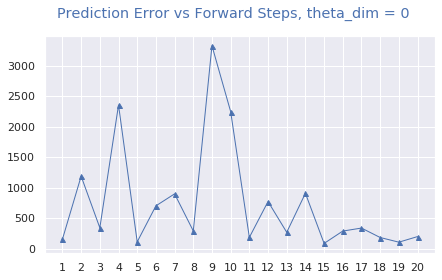

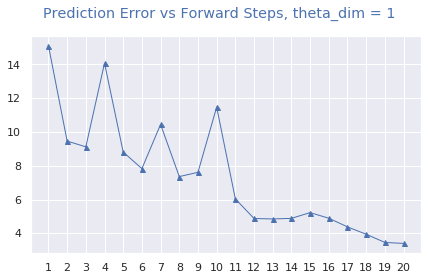

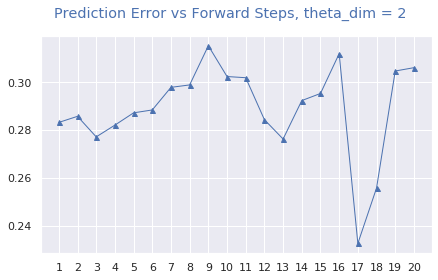

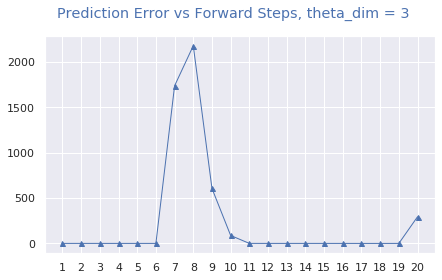

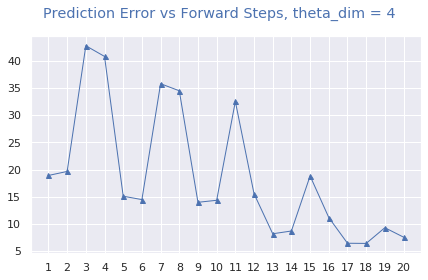

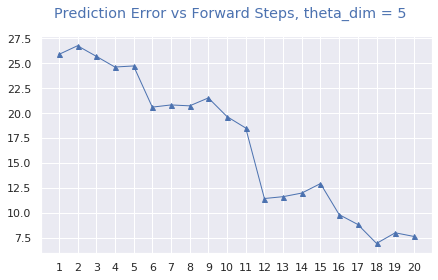

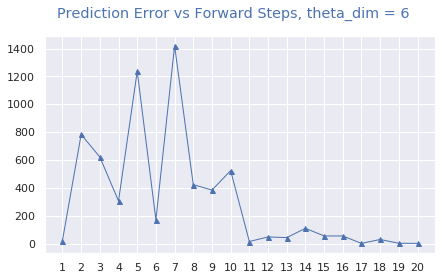

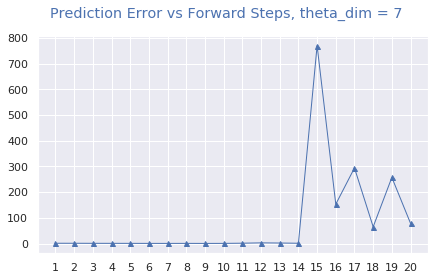

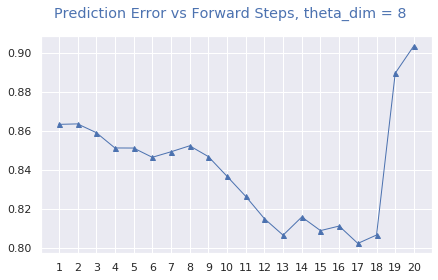

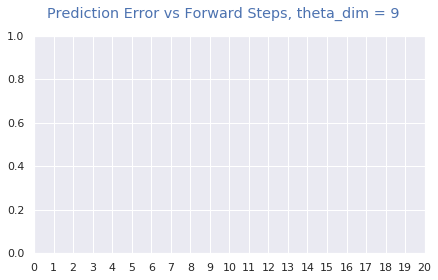

In [7]:
warnings.simplefilter("ignore")

for k in range(num_iters):
    sns.set()
    fig = plt.figure(figsize=(7, 4))
    fig.suptitle('Prediction Error vs Forward Steps, theta_dim = {}'.format(k), color='C0')


    # forward steps
    xlabel = list(range(forward_k+1))
    plt.xticks(xlabel)
    show = error_for_all_theta_dim[k]
    plt.plot([i+1 for i in range(forward_k)], show, marker='^', markersize= 5, linewidth=1)
    fig.show()

# # for i, p in enumerate(show):
# #     print("{:2}-step error {:.4f}".format(i+1, p))

# # print("AVERAGE error {:.4f}".format(np.average(show)))
    

In [14]:
print("error 1: {:.4f}".format(error_for_all_theta_dim[2][0]))
print("error 5: {:.4f}".format(error_for_all_theta_dim[2][4]))
print("error 10: {:.4f}".format(error_for_all_theta_dim[2][9]))
print("error 15: {:.4f}".format(error_for_all_theta_dim[2][14]))
print("error 20: {:.4f}".format(error_for_all_theta_dim[2][19]))

error 1: 0.2833
error 5: 0.2873
error 10: 0.3025
error 15: 0.2954
error 20: 0.3062
